In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [2]:
from google.colab import files
files.upload()

Saving datasets.py to datasets.py


{'datasets.py': b'import numpy as np\n\n\nclass MNISTDataset:\n    """\'Bare minimum\' class to wrap MNIST numpy arrays into a dataset."""\n    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,\n                 to01=True, shuffle=True, seed=None):\n        """\n        Use seed optionally to always get the same shuffling (-> reproducible\n        results).\n        """\n        self.batch_size = batch_size\n        self.train_data = train_imgs\n        self.train_labels = train_lbs.astype(np.int32)\n        self.test_data = test_imgs\n        self.test_labels = test_lbls.astype(np.int32)\n\n        if to01:\n            # int in [0, 255] -> float in [0, 1]\n            self.train_data = self.train_data.astype(np.float32) / 255\n            self.test_data = self.test_data.astype(np.float32) / 255\n\n        self.size = self.train_data.shape[0]\n\n        if seed:\n            np.random.seed(seed)\n        if shuffle:\n            self.shuffle_train()\n        

11493376/11490434 [==============================] - 0s 0us/step
Loss: 2.3025853633880615 Accuracy: 0.09375
Loss: 0.3098723888397217 Accuracy: 0.921875
Loss: 0.32532477378845215 Accuracy: 0.890625
Starting new epoch...
Loss: 0.39717936515808105 Accuracy: 0.8984375
Loss: 0.41609856486320496 Accuracy: 0.875
Starting new epoch...
Loss: 0.1643703579902649 Accuracy: 0.953125
Loss: 0.17858803272247314 Accuracy: 0.9375
Loss: 0.18324029445648193 Accuracy: 0.96875
Starting new epoch...
Loss: 0.19313345849514008 Accuracy: 0.953125
Loss: 0.2504897117614746 Accuracy: 0.9453125
Starting new epoch...
tf.Tensor(0.9554, shape=(), dtype=float32)


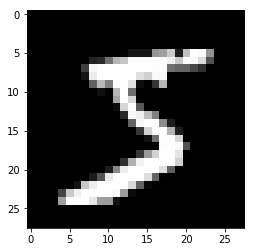

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import MNISTDataset

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[0], cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)


train_steps = 2000
learning_rate = 0.1
coefficient = 0.5


#Initializing variables to 0 will not work for multilayer perceptrons:
#When the weights are initialized to 0 , all outputs of the hidden layer are the 
#same , so the gradient of the loss function is the same for each weight , and the 
#weights will have the same value in iterations.
#the profermance of the MLP is better at using random.normal 
#than with random.uniform(dont know why)
W1 = tf.Variable(tf.compat.v1.random.normal([784,500], stddev=0.1))
b1 = tf.Variable(tf.constant(0.1,shape=[500]))

W2 = tf.Variable(np.zeros([500, 10]).astype(np.float32))
b2 = tf.Variable(np.zeros(10, dtype=np.float32))




for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        logits = tf.matmul(tf.nn.relu(tf.matmul(img_batch, W1) + b1),W2)+b2
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
           logits=logits, labels=lbl_batch))
    grads = tape.gradient(xent, [W1,b1,W2, b2])
    W1.assign_sub(learning_rate * grads[0])
    b1.assign_sub(learning_rate * grads[1])
    W2.assign_sub(learning_rate * grads[2])
    b2.assign_sub(learning_rate * grads[3])
    
    if not step % 200:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

        
test_preds = tf.argmax(tf.matmul(tf.nn.relu(tf.matmul(data.test_data, W1) + b1),W2)+b2, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)



#Which of these parts do you think should be wrapped in higher-level interfaces?
#I think the part about gradient descent and applying gradients to variables 
#should be wrapped in higher-level interfaces